In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
url = "https://raw.githubusercontent.com/Hunteracademic/Unsupervised_assignment_1/master/Country-data.csv"

country_data = pd.read_csv(url)

In [21]:
country_data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [22]:
country_data.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [23]:
country_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [24]:
print(country_data.duplicated().sum())

0


In [25]:
print(country_data.isna().sum())

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64


In [26]:
No_country_data = country_data.drop("country", axis=1)

No_country_data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


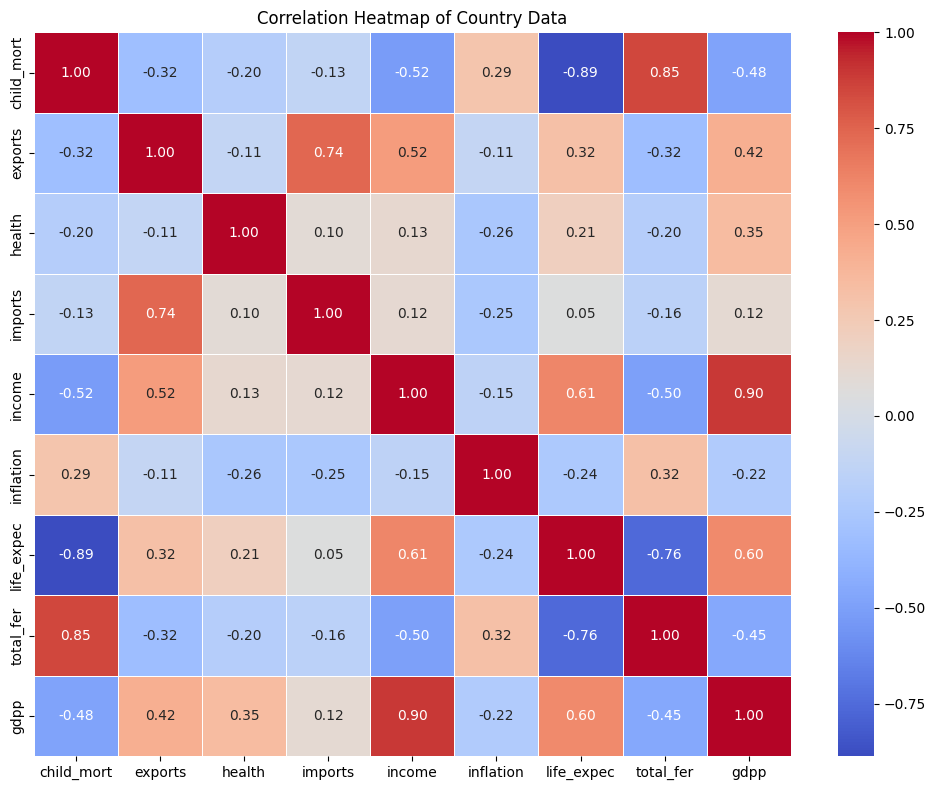

In [27]:
corr = No_country_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5
)
plt.title("Correlation Heatmap of Country Data")
plt.tight_layout()
plt.show()

In [28]:
def scatterPlot(df, xColumn: str, yColumn: str, ax):
    '''
    Scatterplot
    '''
    scatterplot = df.plot.scatter(
        x= xColumn, y= yColumn,
        colormap='inferno', ax=ax, figsize=(18, 6)
    )
    ax.tick_params(axis='x')
    ax.set_title(f"{xColumn} and {yColumn}")
    return scatterplot



The following are the highest correlating columns based on the heat map. 
 Highest to lowest:



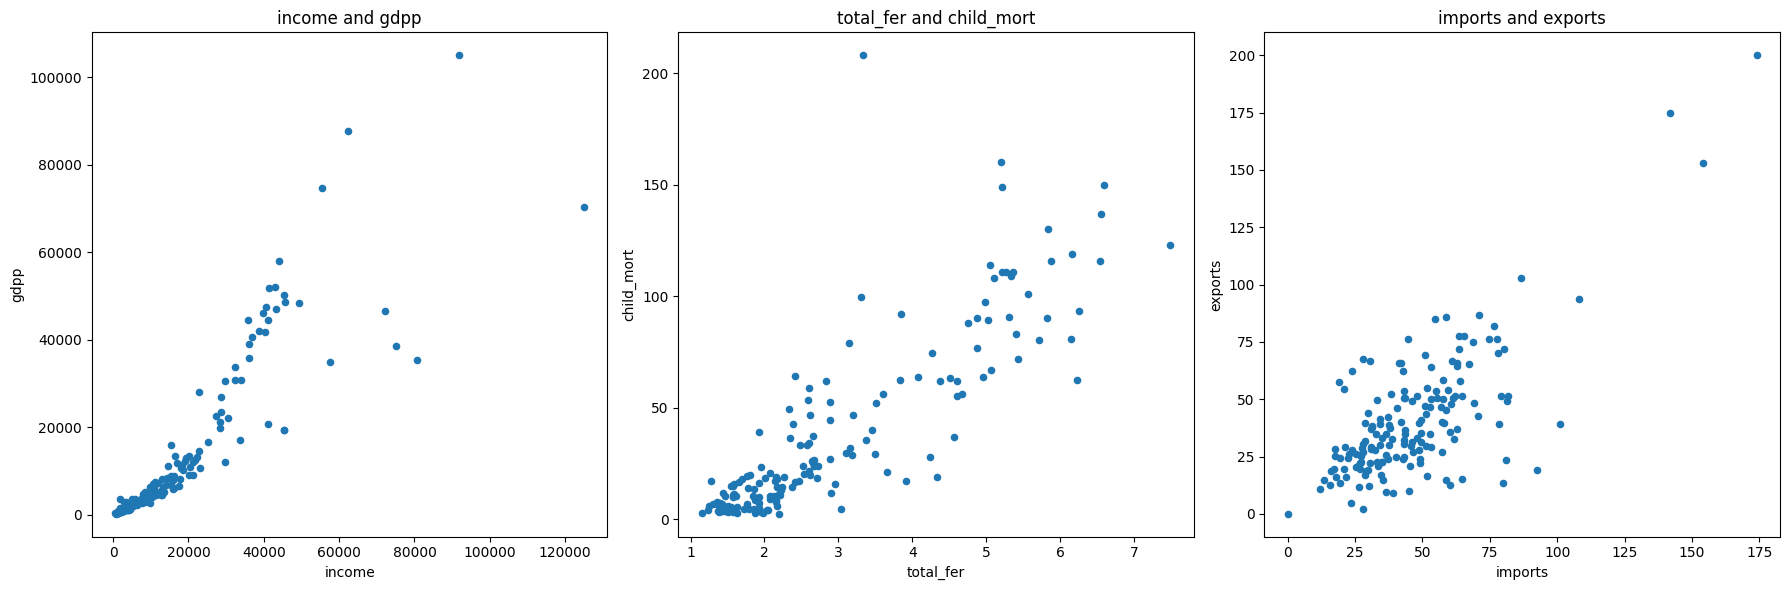

The following are the lowest correlating columns based on the heat map. 
Lowest to highest:



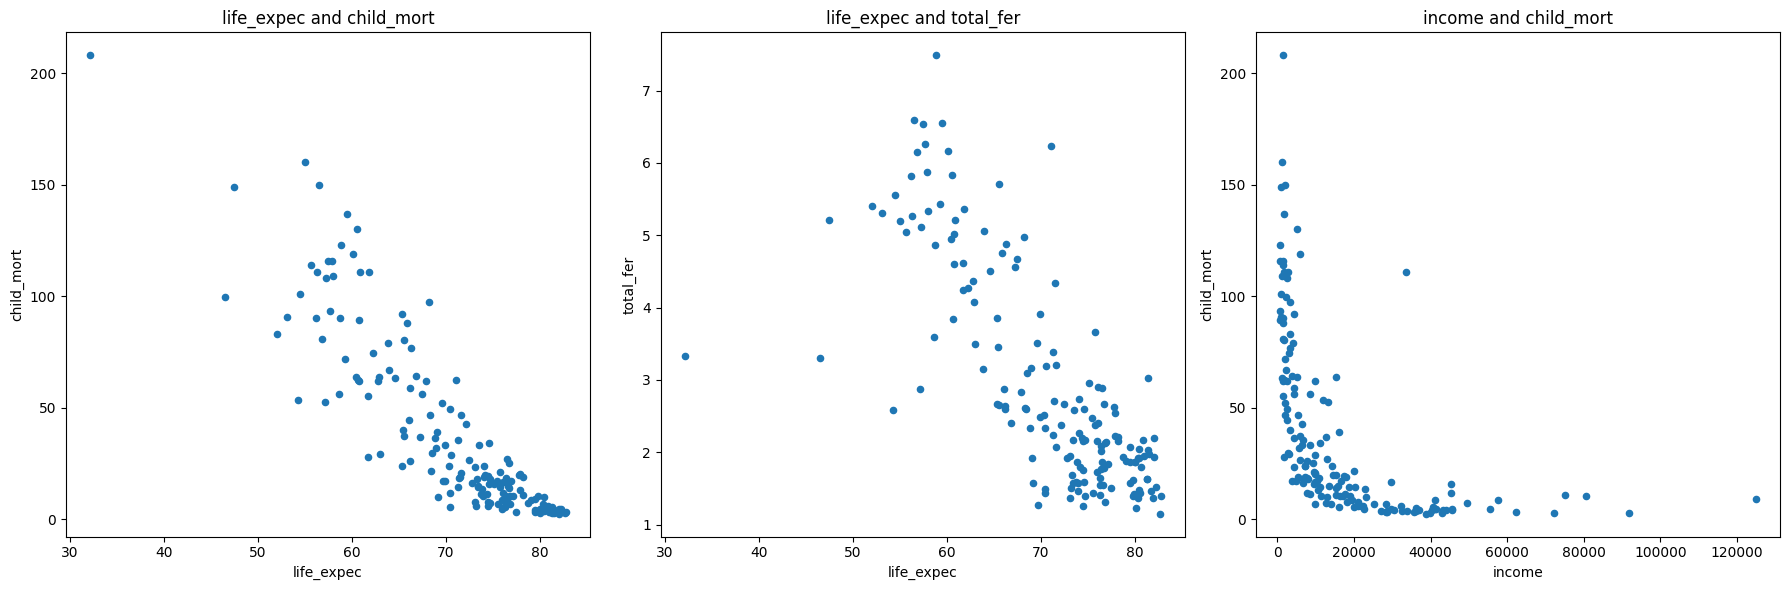

In [29]:
print("The following are the highest correlating columns based on the heat map. \n Highest to lowest:\n")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22, 6))

scatterPlot(No_country_data, 'income', 'gdpp',  axes[0])
scatterPlot(No_country_data, 'total_fer', 'child_mort',  axes[1])
scatterPlot(No_country_data, 'imports', 'exports', axes[2])

plt.tight_layout()
plt.show()

print("The following are the lowest correlating columns based on the heat map. \nLowest to highest:\n")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22, 6))

scatterPlot(No_country_data, 'life_expec', 'child_mort',  axes[0])
scatterPlot(No_country_data, 'life_expec', 'total_fer',  axes[1])
scatterPlot(No_country_data, 'income', 'child_mort', axes[2])

plt.tight_layout()
plt.show()

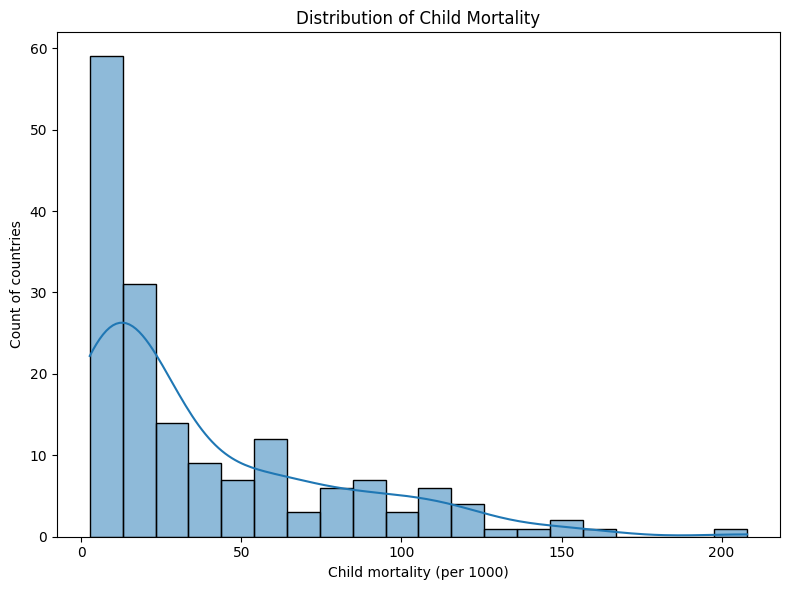

In [30]:
plt.figure(figsize=(8, 6))
sns.histplot(
    data=No_country_data,
    x="child_mort",
    bins=20,
    kde=True
)
plt.title("Distribution of Child Mortality")
plt.xlabel("Child mortality (per 1000)")
plt.ylabel("Count of countries")
plt.tight_layout()
plt.show()